# PAS Velocity Distribution Function (VDF) Plotting Tutorial

Greetings !

Below is a guide to plot proton velocity-space distribution functions (VDFs) from the PAS instrument. 

This code produces the plots of the velocity distribution fonction for the following views :  
         - Plot of Vx/Vz in the elevation plane (with the magnetic field vector)  
         - Plot of Vx/Vy in the azimuth plane (with the magnetic field vector)  
         - Plot of the Vpar/Vperp (velocities parallel and perpendicular to the magnetic field)  

If you are only interested into the code containing the code to plot all the plots in a desired time interval skip to the last cell.

# Step 1

First, we import the cdf reader from cdflib (the library able to read the data encoded in the cdf format). We also import 'numpy' for math operations and 'datetime' for time unit conversions.

In [50]:
import cdflib
import numpy as np
import os.path
import math as m
import matplotlib.pyplot as plt
from spacepy import pycdf

from datetime import datetime
import bisect

from matplotlib import ticker, cm
import warnings 
warnings.filterwarnings("ignore")

from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

# Step 2 

Download the data and look into the cdf files to isolate the variables necessary to our calculations. 

The files used are those of solar orbiter downloaded on https://soar.esac.esa.int/soar/ at the right date and on the L2 level.

In [39]:
#open CDF file

dat = cdflib.CDF('./Data/solo_L2_swa-pas-vdf_20220326_V02.cdf')
infile = cdflib.CDF('./Data/solo_L2_mag-srf-normal_20220326_V01.cdf')

#print variable names in CDF files
#print(dat._get_varnames())

# Step 3 

In the following step we are defining some variables from the cdf files. Afterwards, we are reshaping the data. Indeed, we are only creating tables with values that are repating themselves. No worries it is only to make the plots easier. Moreover, at the end of the cell we are removing 2 set of values in the vdf at the border of the field of view in the azimuth plane. This will not change the results at all it is made to make symmetric tables to easy the calculations. 

In [40]:
epoch_ns        = dat['Epoch']
elevation       = dat['Elevation']
azimuth         = dat['Azimuth']
energy          = dat['Energy']
vdf             = dat['vdf']
mag_field       = infile['B_SRF']
epoch_mag       = infile['EPOCH']

## Making the data in the good shape ##

temp = []
for i in range (9):
    for j in range(96):
        for k in range(9):
            temp.append(energy[j])
energyLine = np.array(temp)
#print(energyLine.shape)


temp1 = []
for i in range (864):
    for j in range(9):
        temp1.append(elevation[j])
elevationLine = np.array(temp1)
#print(elevationLine.shape)

temp2 = []
for i in range (9):
    for j in range (864):
        temp2.append(azimuth[i])
azimuthLine = np.array(temp2)
#print(azimuthLine.shape)

vdf_temp = np.delete(vdf,10,0)
vdfLine = np.delete(vdf_temp,9,0)
#print(vdf.shape)


# Step 4

Type which timeslice you would like to plot in the format (year, month, day, hour, minute, second). Be sure to make the date of the cell correspond to the date in the file of the second cell in order not to have timeindex errors. 

For now it is set up to input a single day, but in the last cell of this tutorial we will implement a time range.

In [41]:
#convert time
import datetime
epoch = cdflib.cdfepoch.to_datetime(epoch_ns)
epoch_mag_conv = cdflib.cdfepoch.to_datetime(epoch_mag)
#print(epoch)

year=2022
month=3
day=26
hour = 17
minute = 24
second = 0

timeSlice  = datetime.datetime(year, month, day, hour, minute, second)
print('Desired timeslice:',timeSlice,'\n')

#find index for desired timeslice
tSliceIndex      = bisect.bisect_left(epoch,timeSlice)
tSliceIndex_mag  = bisect.bisect_left(epoch_mag_conv,timeSlice)
print('Time Index For Vdf:',tSliceIndex)
print('Time of closest data point for Vdf:',epoch[tSliceIndex],'\n')
print('Time Index For Mag:',tSliceIndex_mag)
print('Time of closest data point for Mag:',epoch_mag_conv[tSliceIndex_mag])

Desired timeslice: 2022-03-26 17:24:00 

Time Index For Vdf: 14581
Time of closest data point for Vdf: 2022-03-26 21:03:05.313085 

Time Index For Mag: 501123
Time of closest data point for Mag: 2022-03-26 17:24:00.032003


# Step 5

Afterwards we have to slice the data to the right time slice and retrive the magnetic field to calculate the magnetic field vector (Bx,By,Bz) and to make the calculation of Vpar/Vperp (the velocities perpendicular and parallel to the magnetic field)

In [51]:
elevationSlice  = elevationLine
azimuthSlice    = azimuthLine
energySlice     = energyLine
vdfSlice        = vdfLine[tSliceIndex,:]

## Magnetic coordinates used to calculate the magnetic field vector

Bx = mag_field[tSliceIndex_mag,0]
By = mag_field[tSliceIndex_mag,1]
Bz = mag_field[tSliceIndex_mag,2]

## Magnetic coordinates used to calculate Vpar/Vperp
Bx1 = mag_field[tSliceIndex_mag,0]
By1 = mag_field[tSliceIndex_mag,1]
Bz1 = mag_field[tSliceIndex_mag,2]

In order to make the calculation and the code easier we reshape the data to the vdf shape (more readable format reflecting 9-azimuth-direction bins, 32 energy bins, and 9-elevation-direction bins)

In [43]:
vdf_temp = np.delete(vdfSlice,10,0)
vdfSliceFin = np.delete(vdf_temp,9,0)

elevationReshaped  = elevationSlice.reshape((9,96,9))
azimuthReshaped    = azimuthSlice.reshape((9,96,9))
energyReshaped     = energySlice.reshape((9,96,9))

In [44]:
mass_p = 0.010438870      #proton mass in units eV/c^2 where c = 299792 km/s
charge_p = 1              #proton charge in units eV

# Step 6

We are then plotting on the first plane, the elevation one to display Vx counter Vz. So to do that we cut through the elevation plane that is on dimension 0 for the azimuth,elevation, and energy and on the first axis for the vdf.   
The limits of the plots must be chose manually to center the plot the best. Moreover, the origin of the magnetic field vector can be choosen as one wishes either on the center of the bulk flow velocity or the center of the plot etc...

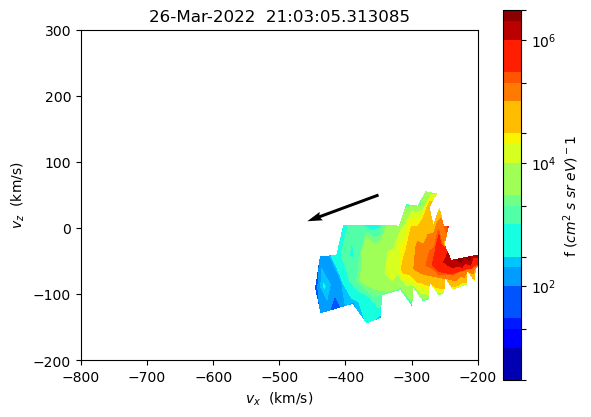

In [45]:
#elevation is along dimension 0, while azimuth is along 1
#first cut through elevation
elevation_cut = 0

azimuth_plane   = azimuthReshaped[elevation_cut,:,:]
elevation_plane = elevationReshaped[elevation_cut,:,:]
energy_plane    = energyReshaped[elevation_cut,:,:]

#Convert to velocity units in each energy channel
vel_plane       = np.sqrt(2*charge_p*energy_plane/mass_p)

df_elevation=np.transpose(np.nansum(vdfSliceFin,axis=1))*(10**12)

#Rotate from energy-angle space to cartesian (vx,vy,vz) space (still in the SRF frame)
vx_plane_elevation = -vel_plane * np.cos(np.radians(azimuth_plane)) * np.cos(np.radians(elevation_plane))
vy_plane_elevation = vel_plane * np.sin(np.radians(azimuth_plane)) * np.cos(np.radians(elevation_plane))
vz_plane_elevation = -vel_plane * np.sin(np.radians(elevation_plane))

fig,ax = plt.subplots()
cs = ax.contourf(vx_plane_elevation, vz_plane_elevation, df_elevation,cmap='jet',locator=ticker.LogLocator(subs=(1,2,3)))
cbar = fig.colorbar(cs)
cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

origin = [-350], [50]
magnetic = ax.quiver(*origin,Bx,Bz,color='k',scale=120)

xmin = -800
xmax = -200
ymin = -200
ymax = 300

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_aspect(1)
ax.set_xlabel('$v_x$  (km/s)')
ax.set_ylabel('$v_z$  (km/s)')
ax.set_title(epoch[tSliceIndex].strftime('%d-%h-%Y  %T.%f'))
plt.savefig('./26_02_2022/VDF_XZ_' + str(day) + '_' + str(month) + '_' + str(year) + '_' + str(hour) +'h_' + str(minute) +'min', dpi= 1200)
    
plt.show()


We are then plotting on the second plane, the azimuth one to display Vx counter Vy. So to do that we cut through the azimuth plane that is on dimension 0 for the azimuth,elevation, and energy and on the first axis for the vdf. 

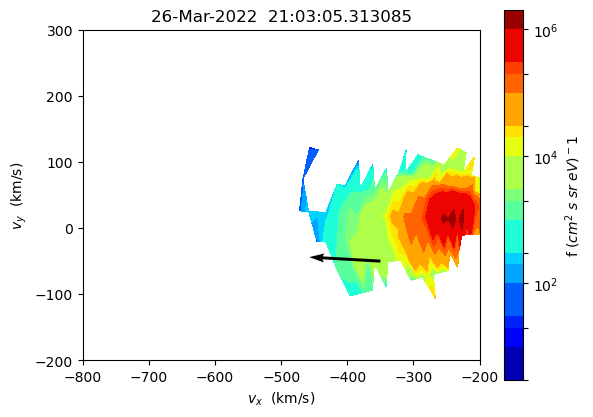

In [46]:
#now repeat for azimuth dimension
azimuth_cut = 1

azimuth_plane   = azimuthReshaped[:,:,azimuth_cut]
elevation_plane = elevationReshaped[:,:,azimuth_cut]
energy_plane    = energyReshaped[:,:,azimuth_cut]
vel_plane       = np.sqrt(2*charge_p*energy_plane/mass_p)

df_azimuth=np.nansum(vdfSliceFin,axis=0)*(10**12)

vx_plane_azimuth = -vel_plane * np.cos(np.radians(azimuth_plane)) * np.cos(np.radians(elevation_plane))
vy_plane_azimuth = vel_plane * np.sin(np.radians(azimuth_plane)) * np.cos(np.radians(elevation_plane))
vz_plane_azimuth = -vel_plane * np.sin(np.radians(elevation_plane))

fig,ax = plt.subplots()
cs = ax.contourf(vx_plane_azimuth, vy_plane_azimuth,df_azimuth,locator=ticker.LogLocator(subs=(1,2,3)),cmap='jet')
cbar = fig.colorbar(cs,ticklocation='top')
cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

origin = [-350], [-50]
magnetic = ax.quiver(*origin,Bx,By,color='k',scale=120)

xmin1 = -800
xmax1 = -200
ymin1 = -200
ymax1 = 300

ax.set_xlim(xmin1,xmax1)
ax.set_ylim(ymin1,ymax1)
ax.set_aspect(1)
ax.set_xlabel('$v_x$  (km/s)')
ax.set_ylabel('$v_y$  (km/s)')
ax.set_title(epoch[tSliceIndex].strftime('%d-%h-%Y  %T.%f'))
plt.savefig('./26_02_2022/VDF_XY_' + str(day) + '_' + str(month) + '_' + str(year) + '_' + str(hour) +'h_' + str(minute) +'min', dpi= 1200)
    
plt.show()


# Magnetic Field-Aligned-Coordinates

Now that we have plotted in the XYZ coordinates we also want to plot in the magnetic field direction in the PAS instrument coordinates, we can rotate the processed data into field-aligned coordinates. We will define two processes here below, one of which will output the elements of a rotation matrix from instrument to field-aligned coordinates (made up of the three unit vectors defining those coordinates), and another which will rotate an input vector from instrument to field-aligned coordinates.

This process will make several assumptions, the largest being that the magnetic field is perfectly defined by each measurement over the course of the PAS collection period.

In [2]:
def fieldAlignedCoordinates(Bx, By, Bz):
    '''
    INPUTS:
         Bx, By, Bz = rank1 arrays of magnetic field measurements in instrument frame
    '''
    import numpy as np


    Bmag = np.sqrt(Bx**2 + By**2 + Bz**2)

    # Define field-aligned vector
    Nx = Bx/Bmag
    Ny = By/Bmag
    Nz = Bz/Bmag

    # Make up some unit vector
    if np.isscalar(Nx):
        Rx = 0
        Ry = 0.9
        Rz = 0
    else:
        Rx = np.zeros(Nx.len())
        Ry = np.ones(len(Nx))
        Rz = np.zeros(len(Nx))

    # Find some vector perpendicular to field NxR 
    TEMP_Px = ( Ny * Rz ) - ( Nz * Ry )  # P = NxR
    TEMP_Py = ( Nz * Rx ) - ( Nx * Rz )  # This is temporary in case we choose a vector R that is not unitary
    TEMP_Pz = ( Nx * Ry ) - ( Ny * Rx )


    Pmag = np.sqrt( TEMP_Px**2 + TEMP_Py**2 + TEMP_Pz**2 ) #Have to normalize, since previous definition does not imply unitarity, just orthogonality
  
    Px = TEMP_Px / Pmag # for R=(0,1,0), NxR = P ~= RTN_N
    Py = TEMP_Py / Pmag
    Pz = TEMP_Pz / Pmag
    
    Qx = ( Pz * Ny ) - ( Py * Nz )   # N x P
    Qy = ( Px * Nz ) - ( Pz * Nx )  
    Qz = ( Py * Nx ) - ( Px * Ny )  

    return(Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)


# ###
# ### TRANSFORM VECTOR DATA INTO FIELD-ALIGNED COORDINATES
# ###

def rotateVectorIntoFieldAligned(Ax, Ay, Az, Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz):
    # For some Vector A in the SAME COORDINATE SYSTEM AS THE ORIGINAL B-FIELD VECTOR:

    An = (Ax * Nx) + (Ay * Ny) + (Az * Nz)  # A dot N = A_parallel
    Ap = (Ax * Px) + (Ay * Py) + (Az * Pz)  # A dot P = A_perp (~RTN_N (+/- depending on B), perpendicular to s/c y)
    Aq = (Ax * Qx) + (Ay * Qy) + (Az * Qz)  # 

    return(An, Ap, Aq)


Below is an intermidiate process to make the calculation of the average value of a table

In [3]:
def average_table(tableau):
    total = 0
    elements = 0
    for ligne in tableau:
        for element in ligne:
            total += element
            elements += 1
    moyenne = total / elements
    return moyenne

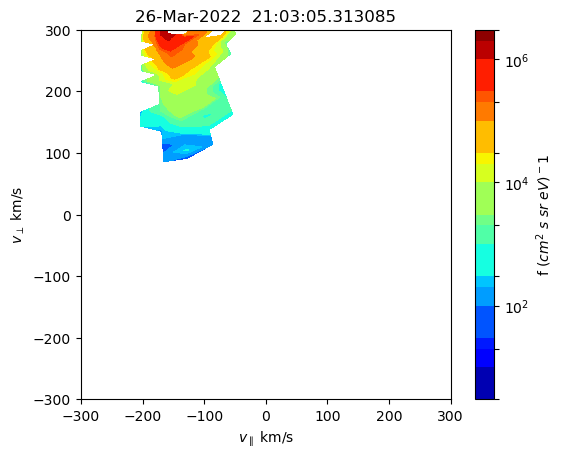

In [49]:
(Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz) = fieldAlignedCoordinates(Bx1, By1, Bz1)

vx_av = average_table(vx_plane_elevation)
vy_av = average_table(vy_plane_elevation)
vz_av = average_table(vz_plane_elevation)

(vn_plane, vp_plane, vq_plane) = rotateVectorIntoFieldAligned(vx_plane_elevation-vx_av, vy_plane_elevation-vy_av, vz_plane_elevation-vz_av, Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)

fig,ax=plt.subplots()
cs=ax.contourf(-vp_plane, -vn_plane, df_elevation,locator=ticker.LogLocator(subs=(1,2,3)),cmap='jet')
cbar = fig.colorbar(cs)
cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

ax.set_xlim(-300,300)
ax.set_ylim(-300,300)
ax.set_aspect(1)
ax.set_ylabel('$v_\perp$ km/s')
ax.set_xlabel('$v_\parallel$ km/s')
ax.set_title(epoch[tSliceIndex].strftime('%d-%h-%Y  %T.%f'))
plt.savefig('./26_02_2022/VDF_ParPerp_' + str(day) + '_' + str(month) + '_' + str(year) + '_' + str(hour) +'h_' + str(minute) +'min', dpi= 1200)
    

plt.show()

To finish, below you have a code containing all the parts of code that were presented before and we added a part of code in ordrer to make the plots of all the desired timeslices from a starting point of time using 2 for loops

Desired timeslice: 2022-03-25 00:00:00 

Time Index For Vdf: 0
Time of closest data point for Vdf: 2022-03-25 00:00:01.025013 

Time Index For Mag: 0
Time of closest data point for Mag: 2022-03-25 00:00:00.081995


FileNotFoundError: [Errno 2] No such file or directory: './26_02_2022/VDF_XZ_25_3_2022_0h_0min.png'

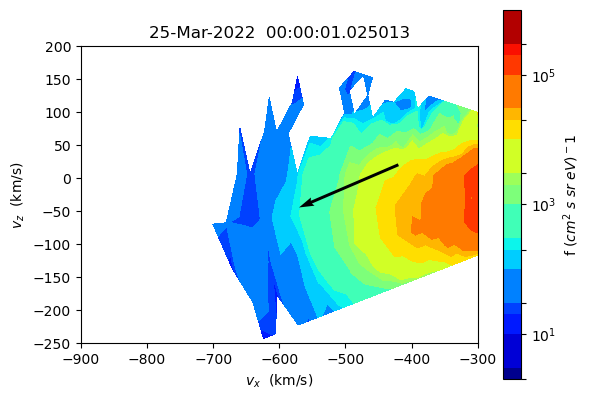

In [4]:
import cdflib
import numpy as np
import os.path
import math as m
import matplotlib.pyplot as plt
from spacepy import pycdf

import wget

from datetime import datetime
import bisect

from matplotlib import ticker, cm
import warnings 
warnings.filterwarnings("ignore")

from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

###### Open CDF file #####
dat1 = cdflib.CDF('./Data/solo_L2_swa-pas-vdf_20220325_V02.cdf')
infile = cdflib.CDF('./Data/solo_L2_mag-srf-normal_20220325_V01.cdf')

##### Retrieving The Variables #####

epoch_ns        = dat1['Epoch']
elevation       = dat1['Elevation']
azimuth         = dat1['Azimuth']
energy          = dat1['Energy']
vdf             = dat1['vdf']
mag_field       = infile['B_SRF']
epoch_mag       = infile['EPOCH']

mass_p = 0.010438870      #proton mass in units eV/c^2 where c = 299792 km/s
charge_p = 1              #proton charge in units eV

## Making the data in the good shape ##

temp = []
for i in range (9):
    for j in range(96):
        for k in range(9):
            temp.append(energy[j])
energyLine = np.array(temp)

temp1 = []
for i in range (864):
    for j in range(9):
        temp1.append(elevation[j])
elevationLine = np.array(temp1)

temp2 = []
for i in range (9):
    for j in range (864):
        temp2.append(azimuth[i])
azimuthLine = np.array(temp2)

vdf_temp = np.delete(vdf,10,0)
vdfLine = np.delete(vdf_temp,9,0)

###### Choosing the right time slice that we want #####

import datetime
epoch = cdflib.cdfepoch.to_datetime(epoch_ns)
epoch_mag_conv = cdflib.cdfepoch.to_datetime(epoch_mag)

for hour in range (0,24) : ## Selecting the hour interval of the plots
    for minute in range (0,60,15): ## Selecting the minute interval in each hour 
        
        # Choose the right date
        
        year=2022
        month=3
        day=25 
        second = 0
        
        timeSlice  = datetime.datetime(year, month, day, hour, minute, second)
        print('Desired timeslice:',timeSlice,'\n')

        tSliceIndex      = bisect.bisect_left(epoch,timeSlice)
        tSliceIndex_mag  = bisect.bisect_left(epoch_mag_conv,timeSlice)
        print('Time Index For Vdf:',tSliceIndex)
        print('Time of closest data point for Vdf:',epoch[tSliceIndex],'\n')
        print('Time Index For Mag:',tSliceIndex_mag)
        print('Time of closest data point for Mag:',epoch_mag_conv[tSliceIndex_mag])

##### Making The Data in the right format to make calculations #####

        elevationSlice  = elevationLine
        azimuthSlice    = azimuthLine
        energySlice     = energyLine
        vdfSlice        = vdfLine[tSliceIndex,:]

        Bx = mag_field[tSliceIndex_mag,0]
        By = mag_field[tSliceIndex_mag,1]
        Bz = mag_field[tSliceIndex_mag,2]
        
        Bx1 = mag_field[tSliceIndex_mag,0]
        By1 = mag_field[tSliceIndex_mag,1]
        Bz1 = mag_field[tSliceIndex_mag,2]

        vdf_temp = np.delete(vdfSlice,10,0)
        vdfSliceFin = np.delete(vdf_temp,9,0)

        elevationReshaped  = elevationSlice.reshape((9,96,9))
        azimuthReshaped    = azimuthSlice.reshape((9,96,9))
        energyReshaped     = energySlice.reshape((9,96,9))
    
##### Making the XYZ plots for the VDF #####

### elevation is along dimension 0, while azimuth is along 1
#first cut through elevation
        
        elevation_cut = 0

        azimuth_plane   = azimuthReshaped[elevation_cut,:,:]
        elevation_plane = elevationReshaped[elevation_cut,:,:]
        energy_plane    = energyReshaped[elevation_cut,:,:]
        vel_plane       = np.sqrt(2*charge_p*energy_plane/mass_p)

        df_elevation=np.transpose(np.nansum(vdfSliceFin,axis=1))*(10**12)

        vx_plane_elevation = -vel_plane * np.cos(np.radians(azimuth_plane)) * np.cos(np.radians(elevation_plane))
        vy_plane_elevation = vel_plane * np.sin(np.radians(azimuth_plane)) * np.cos(np.radians(elevation_plane))
        vz_plane_elevation = -vel_plane * np.sin(np.radians(elevation_plane))
    
        fig,ax = plt.subplots()
        cs = ax.contourf(vx_plane_elevation, vz_plane_elevation, df_elevation,cmap='jet',locator=ticker.LogLocator(subs=(1,2,3)))
        cbar = fig.colorbar(cs)
        cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

        xmin = -900
        xmax = -300
        ymin = -250
        ymax = 200

        ax.set_xlim(xmin,xmax)
        ax.set_ylim(ymin,ymax)

        origin = [-420], [20]
        magnetic = ax.quiver(*origin,Bx,Bz,color='k',scale=120)

        ax.set_xlabel('$v_x$  (km/s)')
        ax.set_ylabel('$v_z$  (km/s)')
        ax.set_aspect(1)
        ax.set_title(epoch[tSliceIndex].strftime('%d-%h-%Y  %T.%f'))
        plt.savefig('./26_02_2022/VDF_XZ_' + str(day) + '_' + str(month) + '_' + str(year) + '_' + str(hour) +'h_' + str(minute) +'min', dpi= 1200)
    
### now repeat for azimuth dimension
        azimuth_cut = 1

        azimuth_plane   = azimuthReshaped[:,:,azimuth_cut]
        elevation_plane = elevationReshaped[:,:,azimuth_cut]
        energy_plane    = energyReshaped[:,:,azimuth_cut]
        vel_plane       = np.sqrt(2*charge_p*energy_plane/mass_p)

        df_azimuth=np.nansum(vdfSlice,axis=0)*(10**12)
    
        vx_plane_azimuth = -vel_plane * np.cos(np.radians(azimuth_plane)) * np.cos(np.radians(elevation_plane))
        vy_plane_azimuth = vel_plane * np.sin(np.radians(azimuth_plane)) * np.cos(np.radians(elevation_plane))
        vz_plane_azimuth = -vel_plane * np.sin(np.radians(elevation_plane))
    
        fig,ax = plt.subplots()
        cs = ax.contourf(vx_plane_azimuth, vy_plane_azimuth,df_azimuth,locator=ticker.LogLocator(subs=(1,2,3)),cmap='jet')
        cbar = fig.colorbar(cs,ticklocation='top')
        cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

        xmin1 = -900
        xmax1 = -300
        ymin1 = -250
        ymax1 = 200

        ax.set_xlim(xmin1,xmax1)
        ax.set_ylim(ymin1,ymax1)

        origin1 = [-420], [20]
        magnetic = ax.quiver(*origin1,Bx,By,color='k',scale=120)
    
        ax.set_xlabel('$v_x$  (km/s)')
        ax.set_ylabel('$v_y$  (km/s)')
        ax.set_aspect(1)
        ax.set_title(epoch[tSliceIndex].strftime('%d-%h-%Y  %T.%f'))
        plt.savefig('./26_02_2022/VDF_XY_' + str(day) + '_' + str(month) + '_' + str(year) + '_' + str(hour) +'h_' + str(minute) +'min', dpi= 1200)
    
        (Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz) = fieldAlignedCoordinates(Bx1, By1, Bz1)

        vx_av = average_table(vx_plane_elevation)
        vy_av = average_table(vy_plane_elevation)
        vz_av = average_table(vz_plane_elevation)

        (vn_plane, vp_plane, vq_plane) = rotateVectorIntoFieldAligned(vx_plane_elevation-vx_av, vy_plane_elevation-vy_av, vz_plane_elevation-vz_av, Nx, Ny, Nz, Px, Py, Pz, Qx, Qy, Qz)

        fig,ax=plt.subplots()
        cs=ax.contourf(vp_plane, vn_plane, df_elevation,locator=ticker.LogLocator(subs=(1,2,3)),cmap='jet')
        cbar = fig.colorbar(cs)
        cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

        ax.set_xlim(-400,400)
        ax.set_ylim(-250,400)
        
        ax.set_aspect(1)
        ax.set_xlabel('$v_\perp$ km/s')
        ax.set_ylabel('$v_\parallel$ km/s')
        ax.set_title(epoch[tSliceIndex].strftime('%d-%h-%Y  %T.%f'))
        plt.savefig('./26_02_2022/VDF_ParPerp_' + str(day) + '_' + str(month) + '_' + str(year) + '_' + str(hour) +'h_' + str(minute) +'min', dpi= 1200)
    
        plt.show()
        

In [1]:
def bi_maxwellian(vx, vy, vz, n, T_perp, T_parallel):
    m = 1.67e-27  # masse du proton en kg
    k = 1.38e-23  # constante de Boltzmann en J/K

    v_perp_squared = vy**2 + vz**2
    v_parallel_squared = vx**2

    factor = n / (np.pi**1.5 * np.sqrt(T_perp * T_parallel**2))

    f = factor * np.exp(-v_perp_squared / T_perp - v_parallel_squared / T_parallel)

    return f

In [ ]:
vx = vx_plane_elevation.flatten()
vy = vy_plane_elevation.flatten()
vz = vz_plane_elevation.flatten()

n = 
T_perp = 
T_parallel = 

f_bi_maxwellian = bi_maxwellian(vx, vy, vz, n, T_perp, T_parallel)

fig, ax = plt.subplots()
cs = ax.contourf(vx.reshape(vx_plane_elevation.shape),
                 vz.reshape(vz_plane_elevation.shape),
                 f_bi_maxwellian.reshape(vx_plane_elevation.shape),
                 cmap='jet', locator=ticker.LogLocator(subs=(1, 2, 3)))
cbar = fig.colorbar(cs)
cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')


plt.show()